____
**Universidad Tecnológica Nacional, Buenos Aires**

**Ingeniería Industrial**

**Cátedra de Ciencia de Datos - Curso I5521 - Turno sabado mañana**

**Elaborado por: Agustin Velazquez**

**Editado por: Nicolas Aguirre**
____

# Google Colaboratory

En esta notebook presentamos la herramienta **Google Colaboratory**.

## Ambiente
Verificamos si estamos en un ambiente de Colab, y si es asi, montamos nuestro google drive y a la maquina virtual sobre la que esta corriendo la notebook.

In [1]:
# Verificamos si estamos en Colab
var_google_colab = 'google.colab' in str(get_ipython())
print(var_google_colab)
if var_google_colab:
  #Montamos nuestro G.Drive
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)

False


## Paths
Vamos a declarar nuestros paths de imagenes y de archivos segun si estamos o no en Colab.


```
"/content/gdrive/My Drive/......."

```
A partir de esta direccion es donde estara nuestra informacion.


In [2]:
if var_google_colab:
  # Direccion root donde está la jupyter-notebook
  root_path = "/content/gdrive/My Drive/Colab Notebooks/ClusterAI/clusterai_2022/clase03/"
  # Direccion donde guardaremos las imagenes
  plot_path = root_path
else:
  # Si, no estamos en google colab, es que estamos corriendo la 
  # en local.
  root_path = "./"
  plot_path = root_path

**Consultas ?**

-------------


# Iris Dataset 

## Descripción

Cuantificar la variación morfológica del Iris con las flores de tres especies relacionadas.

El conjunto de datos contiene `50` muestras de cada una de tres especies de Iris (`Iris setosa`, `Iris virginica` e `Iris versicolor`). Se midió cuatro rasgos de cada muestra: lo largo y lo ancho del sépalos y pétalos, en centímetros. Basado en la combinación de estos cuatro rasgos.

https://es.wikipedia.org/wiki/Iris_flor_conjunto_de_datos

Los datos son:

| Columna | Descripcion |
| --- | --- |
| ID | Unique ID |
| SepalLengthCm | Length of the sepal (cm) |
| SepalWidthCm | Width of the sepal (cm) |
| PetalLengthCm | Length of the petal (cm) |
| PetalWidthCm | Width of the petal (cm) |
| Species | name |

**Objetivo: Clasificar las tres especies de flores segun los datos**

In [3]:
# Importamos algunas de las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import Image

In [4]:
# Cargamos el dataset
col_names = ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm','Species']
iris_df = pd.read_csv(root_path+'iris.csv')
iris_df = iris_df[col_names]
# Observamos una parte de los datos
iris_df.tail(5)

SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm         Species
145            6.7           3.0            5.2           2.3  Iris-virginica
146            6.3           2.5            5.0           1.9  Iris-virginica
147            6.5           3.0            5.2           2.0  Iris-virginica
148            6.2           3.4            5.4           2.3  Iris-virginica
149            5.9           3.0            5.1           1.8  Iris-virginica

In [5]:
# Nuestro objetivo es Species, entonces vemos cuanto tenemos
print("Species")
print(iris_df['Species'].unique())

Species
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


## Pairplot: 

**Con un pairplot podemos visualizar facilmente similitudes y diferencias entre especies utilizando dos caracteristicas**

c:\Users\schas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\schas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\schas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

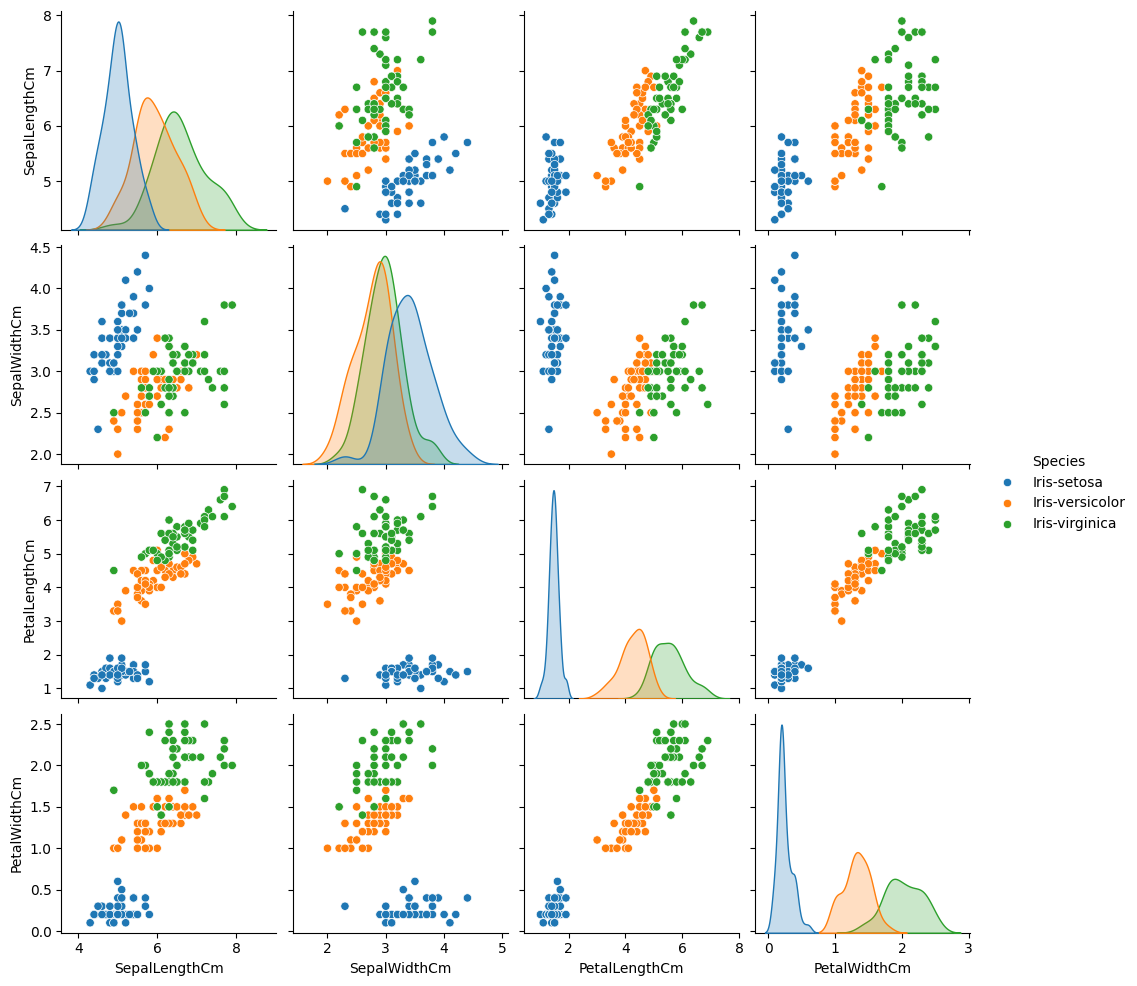

In [6]:
sns.pairplot(data=iris_df, hue='Species')
plt.show()

## Analizando Pairplot

    1. Cual es el significado de los colores?

    2. Que datos podemos extraer de la primer columna del pairplot?
    
    3. Que otras conclusiones se pueden extraer del resto del pairplot?

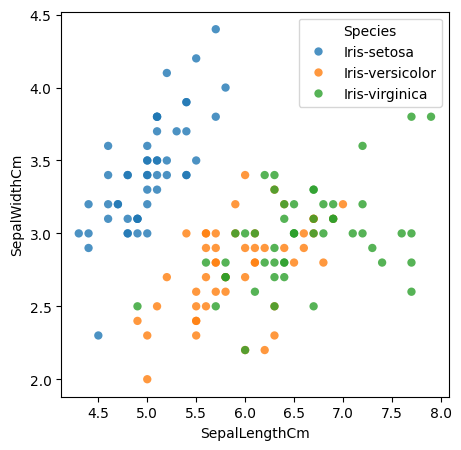

In [7]:
# Un scatter plot para visualizar dos variables
fig, (ax0) = plt.subplots(1,1,figsize=(5,5))
g=sns.scatterplot(x="SepalLengthCm", y="SepalWidthCm", data=iris_df, hue = 'Species', 
                  linewidth=0, alpha = 0.8,ax=ax0)

# Veamos como guardar una imagen,
plot_name = "teste_img"
plot_save = str(plot_path + plot_name)
plt.savefig(plot_save+".pdf",dpi=300)
plt.savefig(plot_save+".png",dpi=300)
plt.show()

## Multi-Class Problem:

**Hay tres tipos de Especies $\rightarrow$ Multi class problem!**

La estrategia que vamos a utilizar es: One vs One 

![Axis diagram](https://image.slidesharecdn.com/linearmodelsandmulticlassclassification2-170312171304/95/linear-models-and-multiclass-classification-25-638.jpg?cb=1489338888)


La idea es desarrollar un `clasificador binario` para cada posible par de clases y luego tener un clasificador `ensamblado`.

Si un problema es multi-class (`n` clases) el `One vs One` va a construir $\frac{n(n-1)}{2}$ modelos. Luego la label va a ser estimada por **el voto de la mayoria**. 

Si tenemos tres clases, `A`, `B` and `C`. El `OVO` va a estar compuesto de $3 = \frac{3(2-1)}{2}$ clasificadores binarios. 
El primero va a clasificar `A` de `B`, el segundo `A` de `C`, y el tercer `B` de
`C`.

Finalmente la muestra $x_i$ va a tener los siguientes labels, e.j. (A, B, B). y por votacion es asignado la clase perteneciente.

* Ventajas

* Desventajas

# Pre-Processing

## Features & Target

In [8]:
# Nombre de columnas
column_names = iris_df.columns.values
# Columna target
targets_name = ['Species']
# Nombres de columnas que no estan en el target
features_names = [i_c for i_c in column_names if i_c not in targets_name]
print('Features:',features_names)
print('Target:',targets_name)

Features: ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
Target: ['Species']


In [9]:
# 1) Separamos lo que son las features del target.
features = iris_df[features_names]           
target = iris_df[targets_name]
print(features)
print(target)

     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0              5.1           3.5            1.4           0.2
1              4.9           3.0            1.4           0.2
2              4.7           3.2            1.3           0.2
3              4.6           3.1            1.5           0.2
4              5.0           3.6            1.4           0.2
..             ...           ...            ...           ...
145            6.7           3.0            5.2           2.3
146            6.3           2.5            5.0           1.9
147            6.5           3.0            5.2           2.0
148            6.2           3.4            5.4           2.3
149            5.9           3.0            5.1           1.8

[150 rows x 4 columns]
            Species
0       Iris-setosa
1       Iris-setosa
2       Iris-setosa
3       Iris-setosa
4       Iris-setosa
..              ...
145  Iris-virginica
146  Iris-virginica
147  Iris-virginica
148  Iris-virginica
149  Iris-vi

In [10]:
# Guardamos feature matrix en "X"
X = features.values
# Guardamos target vector in "Y"
Y = target.values                          

In [11]:
print(Y.shape)
print(X.shape)

(150, 1)
(150, 4)


## Label Encoder
**`LabelEncoder` recibe valores (array o columnas de `Pandas DataFrame`) y le asigna a cada valor unico una clase.** 

**Luego nos devuelve los valores "codificados" entre `0` y `n_clases - 1`.**


In [12]:
# Transformamos el label del target en formato numerico para poder procesarlo

# Importamos preprocessing de la libreria scikit-learn (a.k.a. sklearn)
from sklearn import preprocessing

# 1 - Primero creo un objeto (con determinados argumentos) que llama a la funcion que deseo
le = preprocessing.LabelEncoder()

# 2 - AL objeto le aplico la funcion fit a los datos desados 
Y = le.fit_transform(Y.ravel()) #.ravel() para evitar el warning!

# 3 - Agregamos la nueva columna a nuestro DataFrame
iris_df['EncodedSpecies'] = Y

print('Classes:',le.classes_)
print('Response variable after encoding:',Y)
iris_df.tail(10)

Classes: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Response variable after encoding: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm         Species  \
140            6.7           3.1            5.6           2.4  Iris-virginica   
141            6.9           3.1            5.1           2.3  Iris-virginica   
142            5.8           2.7            5.1           1.9  Iris-virginica   
143            6.8           3.2            5.9           2.3  Iris-virginica   
144            6.7           3.3            5.7           2.5  Iris-virginica   
145            6.7           3.0            5.2           2.3  Iris-virginica   
146            6.3           2.5            5.0           1.9  Iris-virginica   
147            6.5           3.0            5.2           2.0  Iris-virginica   
148            6.2           3.4            5.4           2.3  Iris-virginica   
149            5.9           3.0            5.1           1.8  Iris-virginica   

     EncodedSpecies  
140               2  
141               2  
142               2  
143               2  
144               2  
145               2  
146               2  
147               2  
148               2  
149               2

## Split train & test

In [13]:
# Separar train y test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=4)
#random_state: seed utilizada para poder replicar el experimento ya que la funcion tiene
#componentes aleatorios
#test_size: numero entre 0 y 1 e indicar la proporcion del dataset que va a ser test. 
print(x_train.shape)
print(y_train.shape)

(90, 4)
(90,)


## Scaling

In [14]:
# Auto scaling train-set (mean = 0, std = 1)
scaler = preprocessing.StandardScaler().fit(x_train)
# Los valores de media y var quedan guardados en el scaler.
print(scaler.mean_)
print(scaler.var_)

[5.89       3.05       3.90666667 1.27888889]
[0.65112222 0.15983333 2.78973333 0.55344321]


In [15]:
# Transformamos los datos de x_train ...
x_train_scaled = scaler.transform(x_train)  
print(x_train_scaled.mean(axis=0))
print(x_train_scaled.std(axis=0))

[-1.82570008e-15 -1.78375833e-15  2.02307307e-16  2.07241631e-16]
[1. 1. 1. 1.]


**Ahora vamos a estandarizar los datos de test que una vez aplicado no deben tocarse hasta la validacion**

In [16]:
x_test_scaled = scaler.transform(x_test)
print(x_test_scaled.mean(axis=0))
print(x_test_scaled.std(axis=0))

[-0.14458243  0.02501303 -0.22152379 -0.26958652]
[1.05006824 1.19190877 1.11436585 1.03427381]


**Repasemos...**

- **Cual es el objetivo de escalar los datos?**


- **Por que no escalamos y_test?**


- **Por que $\mu_i \neq 0 $ y $\sigma_i \neq 1$ en `x_test_scaled`?**

# SVM

## GridSearchCV

**Vamos a ver como se utilizan `SVM` en su forma de clasificador (`SVC`) con la libreria `sklearn`.**

**Previamente, crearemos un objeto `GridSearchCV` (Grid Search Cross-Validation) al cual le pasaremos un diccionario (`dict`) de Python cuyas `keys` serán los hyperparametros, y sus `values`, seran los distintos valores que querramos evaluar.**

In [17]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#Creamos el modelo Support Vector Classification (SVC)
svc = svm.SVC()

# Hyperparametros
parameters = {'kernel':('linear', 'rbf'),
              'C':[1, 10, 100, 1000],
              'gamma':[0.0001,0.001, 0.01, 0.1,1, 10,100]}
# 
clf = GridSearchCV(svc, # modelo
                   param_grid = parameters, # Hyperparametros
                   refit = True, # refit nos devuelve el modelo con los mejores parametros encontrados 
                   cv = 5, # cv indica la cantidad de folds
                   verbose=1)
clf.fit(x_train_scaled, y_train.ravel())
# Non-linear SVM
#model = SVC(C=1.0, kernel='rbf', gamma = 'auto' )
#model.fit(x_train_scaled, y_train.ravel())

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ('linear', 'rbf')},
             verbose=1)

**Que quiere decir el mensaje:**

`Fitting 5 folds for each of 56 candidates, totalling 280 fits` ?, De donde sale `56` y `280`?

**Veamos que sucede si aumentamos verbose ...**

In [18]:
# Toda la informacion del entrenamiento esta en cv_results_
scores = clf.cv_results_
#Veamosla ...
scores_df = pd.DataFrame.from_dict(scores)
scores_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.000391      0.000479         0.000000        0.000000       1   
1       0.001004      0.000021         0.000000        0.000000       1   
2       0.000204      0.000408         0.000399        0.000489       1   
3       0.000597      0.000488         0.000402        0.000496       1   
4       0.000600      0.000493         0.000401        0.000491       1   

  param_gamma param_kernel                                         params  \
0      0.0001       linear  {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}   
1      0.0001          rbf     {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}   
2       0.001       linear   {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}   
3       0.001          rbf      {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}   
4        0.01       linear    {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.888889           0.944444           1.000000           1.000000   
1           0.555556           0.444444           0.666667           0.333333   
2           0.888889           0.944444           1.000000           1.000000   
3           0.555556           0.444444           0.666667           0.333333   
4           0.888889           0.944444           1.000000           1.000000   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           1.000000         0.966667        0.044444                1  
1           0.333333         0.466667        0.129577               53  
2           1.000000         0.966667        0.044444                1  
3           0.333333         0.466667        0.129577               53  
4           1.000000         0.966667        0.044444                1

## Guardar csv

In [19]:
csv_name = "CV_results.csv"
csv_save = str(root_path + "CV_results.csv")
scores_df.to_csv(csv_save)

In [20]:
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'} with a score of 0.97


**Que es lo que hizo internamente GridSearchCV?**
 
![Grid_SearchCV](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)
[**Fuente**](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

## Predict
**Utilizando `predict` utilizamos el/los modelos ya entrenada previamente para estimar $\hat{y}$ a partir de `x_test`**

In [21]:
# Prediction sobre las muestras de test
y_pred = clf.predict(x_test_scaled)
print(y_pred)

[2 0 2 2 2 1 2 0 0 1 0 0 0 1 2 0 1 0 0 2 0 2 1 0 0 0 0 0 0 2 1 0 2 0 1 2 2
 1 1 0 2 0 1 0 2 0 0 1 1 2 0 1 2 2 1 1 0 1 2 1]


**Con score**

In [22]:
# Model prediciton
print(clf.score(x_test_scaled,y_test.ravel())) #obtenemos el promedio de la accuracy

0.9666666666666667


## Confusion matrix

**Es un herramienta que permite la visualización del desempeño de un algoritmo que se emplea en aprendizaje supervisado.** 

**Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real.**

**Uno de los beneficios de las matrices de confusión es que facilitan ver si el sistema está classificando erroneamente las clases.**

In [23]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[25  0  0]
 [ 0 16  1]
 [ 0  1 17]]


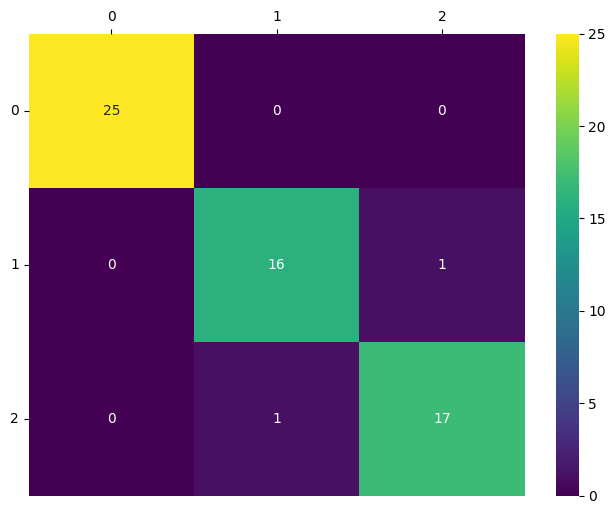

In [24]:
import matplotlib.pyplot as plt
import numpy as np

df_cm = pd.DataFrame(cm, #Valores
                     index = [i for i in np.unique(Y)], # rows
                     columns = [i for i in np.unique(Y)]) # Column
plt.figure(figsize = (8,6))
ax = sns.heatmap(df_cm, annot=True, cmap="viridis")
plt.yticks(rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.show()

# Resumen

1.  Dividimos el dataset en `features` y `target` ( $X$ e $Y$ )
    
2.  Aplicamos un `encoder` a la variable objetivo
    
3.  Separamos nuestro dataset en train y test set $\rightarrow$ ${X}_{train}$, ${Y}_{train}$, ${X}_{test}$, ${Y}_{test}$
    
4.  Estandarizamos el set de entrenamiento ($\mu$ y $\sigma$), y luego ${X}_{test}$. 

5.  Aplicamos un cross validation grid search con kernel linea y gaussiano y diversos parametros sobre el train set

6.  Realizamos la `prediccion` sobre el test set y obtenemos el `score`

7.  Realizamos una `Matriz de Confusion` para obtener una mejor vision del error obtenido

# Extra

Diferencia entre otras funciones con SVM

En el siguiente link https://scikit-learn.org/stable/modules/svm.html#svm-classification encontramos diferentes funciones utilizadas en Sklearn sobre el mismo dataset y los resultados de la clasificacion. 

![Axis diagram](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png)
[**Fuente**](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png)

# Consultas ?

![Meme](https://editor.analyticsvidhya.com/uploads/30927SVM%201.png)

[**Fuente**](https://editor.analyticsvidhya.com/uploads/30927SVM%201.png)